In [1]:
# preamble
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run lib/preamble.py

Using TensorFlow backend.


# Models

In [2]:
%run lib/models.py
d = load_data_desc("amd", source="B", max_seq_len=1024, atomizer=CharacterAtomizer)
m = brandon()["create_model"](data_desc=d)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1024


In [3]:
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
code_in (InputLayer)             (None, 1024)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1024, 64)      5376        code_in[0][0]                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 1024, 64)      33024       embedding_1[0][0]                
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 1024, 64)      0           lstm_1[0][0]                     
___________________________________________________________________________________________

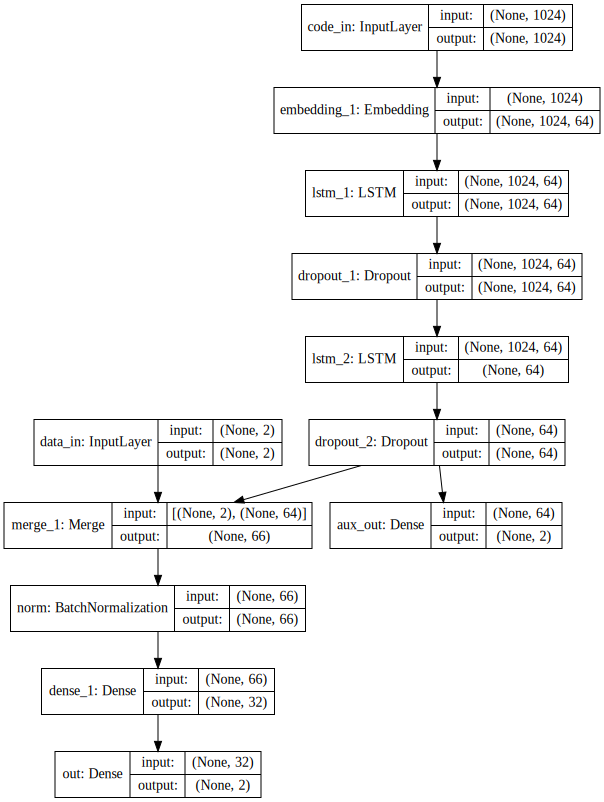

In [4]:
SVG(model_to_dot(m, show_shapes=True).create(prog='dot', format='svg'))

# Evaluate

In [72]:
%run lib/preamble.py
%run lib/models.py

models = ["zero_r", "cgo13", "karl", "sally", "barry", "turner", "fred", "bruno" ]
platforms = ["amd", "nvidia"]
sources = ["B"]#, "BS"]
atomizers = ["GreedyAtomizer"]#, "CharacterAtomizer"]
n_splits = 10
splits = range(n_splits)
seed = 204

data = None

for model, platform, source, atomizer, split_i in product(models, platforms, sources, atomizers, splits):
    result = load_result(globals().get(model)(), platform, source, 
                         atomizer=atomizer, maxlen=1024, seed=seed,
                         n_splits=n_splits, split_i=split_i)
    if not result:
        continue

    frame = result["dataframe"]
    frame["correct"] = result["correct"]
    frame["acc"] = result["correct"] * 100
    frame["p_oracle"] = result["speedups"]
    frame["p_oracle_perc"] = result["speedups"] * 100
    frame["model"] = [model] * len(frame)
    frame["platform"] = [platform] * len(frame)
    frame["atomizer"] = [atomizer] * len(frame)
    frame["model_name"] = model2str(model)
    frame["benchmark_name"] = [escape_benchmark_name(b) for b in frame["benchmark"].values]
    
    zero_r_dev = "runtime_cpu" if platform == "amd" else "runtime_gpu"
    frame["p_speedup"] = np.array(
        [r[zero_r_dev] / r[enc2key(p)]
        for p, r in zip(result["predictions"], frame.to_dict('records'))])
    
    if data is None:
        data = frame
    else:
        data = pd.concat((data, frame))
        
model_names = sorted(set(data["model_name"]))
suite_names = sorted(set(data["source"]))
benchmark_names = sorted(set(data["benchmark_name"]))

d = data.copy()

# Append aggregate "Average" rows:
for platform, atomizer in product(platforms, atomizers):
    # TODO: source B, BS
    msk = (data["platform"] == platform) & (data["atomizer"] == atomizer)
    r = data[msk].groupby('model_name').mean()
    r["source"] = ["Average"] * len(r)
    r["platform"] = [platform] * len(r)
    r["atomizer"] = [atomizer] * len(r)
    r["model_name"] = model_names
    d = d.append(r)

assert(len(d[d["source"] == "Average"]) == len(list(product(platforms, sources, atomizers))) * len(model_names))
data

,benchmark,dataset,comp,rational,mem,localmem,coalesced,atomic,transfer,wgsize,...,seq,correct,acc,p_oracle,p_oracle_perc,model,platform,atomizer,model_name,p_speedup
9,amd-app-sdk-3.0-ScanLargeArrays-ScanLargeArrays,default,32,3,21,14,4,0,263168,128,...,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,0.505803,50.580324,zero_r,amd,GreedyAtomizer,Static mapping,1.000000
11,amd-app-sdk-3.0-ScanLargeArrays-prefixSum,default,31,3,19,13,3,0,263168,64,...,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,0.701699,70.169912,zero_r,amd,GreedyAtomizer,Static mapping,1.000000
25,npb-3.3-BT-compute_rhs2,B,27,4,2,0,2,0,1313675032,32,...,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",False,0,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping,1.000000
26,npb-3.3-BT-compute_rhs2,S,27,4,2,0,2,0,1807992,60,...,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,0.790205,79.020479,zero_r,amd,GreedyAtomizer,Static mapping,1.000000
27,npb-3.3-BT-compute_rhs2,W,27,4,2,0,2,0,15948384,48,...,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping,1.000000
36,npb-3.3-BT-compute_rhs5,A,1260,23,8,0,87,0,320457304,62,...,"[1, 113, 51, 18, 52, 8, 1, 10, 1, 7, 7, 7, 15,...",False,0,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping,1.000000
42,npb-3.3-BT-compute_rhs6,S,16,4,1,0,2,0,1807992,60,...,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping,1.000000
55,npb-3.3-BT-exact_rhs2,W,340,26,5,0,112,0,15948384,44,...,"[8, 8, 1, 9, 1, 7, 20, 13, 15, 1, 9, 1, 123, 5...",True,100,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping,1.000000
69,npb-3.3-BT-initialize1,B,12,4,1,0,1,0,1313675032,32,...,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",False,0,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping,1.000000
74,npb-3.3-BT-initialize2,S,116,10,7,0,40,0,1807992,60,...,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping,1.000000


In [74]:
# print model accuracy and speedup (per-platform)
amd_msk = (data["platform"] == "amd") & (data["atomizer"] == "GreedyAtomizer")
nvidia_msk = (data["platform"] == "nvidia") & (data["atomizer"] == "GreedyAtomizer")

def table(D, sortby='acc'):
    print(D[["model_name", "acc", "p_oracle", "p_speedup"]].groupby(
          "model_name").mean().sort_values(sortby, ascending=False))
    
table(data, sortby="p_speedup")
print("\nAMD:")
table(data[amd_msk], sortby="p_speedup")
print("\nNVIDIA:")
table(data[nvidia_msk], sortby="p_speedup")

                      acc  p_oracle  p_speedup
model_name                                    
Bruno           83.823529  0.723524   2.423378
Fred            82.058824  0.717209   2.390579
Turner          81.470588  0.729473   2.381664
Sally           81.397059  0.729643   2.350925
Karl            82.205882  0.726738   2.324546
Barry           81.397059  0.728680   2.288556
CGO'13          73.161765  0.734061   2.085312
Static mapping  57.867647  0.788421   1.000000

AMD:
                      acc  p_oracle  p_speedup
model_name                                    
Bruno           86.029412  0.705724   3.425412
Fred            83.235294  0.698506   3.384694
Turner          82.647059  0.713623   3.357451
Sally           83.382353  0.721539   3.301438
Karl            85.735294  0.704323   3.263103
Barry           84.117647  0.722663   3.169435
CGO'13          73.382353  0.705625   2.905822
Static mapping  58.823529  0.764933   1.000000

NVIDIA:
                      acc  p_oracle  p_speedu

In [98]:
order = ["AMD", "NPB", "NVIDIA", "Parboil", "Polybench", "Rodinia", "SHOC", "Average"]

def plot_ex1_graph(x="source", y="acc", hue="model_name", order=order, n_palette=len(model_names),
                   data=data, atomizer="CharacterAtomizer", ylabel="Accuracy (%)", ci=None,
                   ylim=(0, 100), yaxis_fmt="%d%%"):
    palette = sns.cubehelix_palette(n_palette, rot=1.8, light=.85, dark=.35)

    for i, platform in enumerate(["amd", "nvidia"]):
        plt.subplot(1, 2, i + 1)
        msk = (data["platform"] == platform) & (data["atomizer"] == atomizer)
        ax = sns.barplot(x=x, y=y, hue=hue, order=order, palette=palette,
                         data=data[msk],
                         ci=ci, errwidth=1, capsize=.08)

        plt.ylim(ylim)
        plt.xlabel("")
        
        # vertical divider for "Average" column
        plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")
        
        if not i:
            # first plot
            plt.ylabel(ylabel)
            ax.legend().set_visible(False)
        else:     
            # second plot
            plt.ylabel("")
            plt.legend(loc='upper left', bbox_to_anchor=(1,1))
            ax.get_legend().set_title("")  # no legend title
            ax.get_legend().draw_frame(True)
            
        from matplotlib.ticker import FormatStrFormatter
        if yaxis_fmt:
            plt.gca().yaxis.set_major_formatter(FormatStrFormatter(yaxis_fmt))
        
        plt.title(platform2str(platform))

    viz.finalise(figsize=(9,2.6))
    
    
def plot_ex2_graph(x="source", y="acc", hue="model_name", order=order, n_palette=len(model_names),
                   data=data, atomizer="CharacterAtomizer", ylabel="Accuracy (%)", ci=None,
                   ylim=(0, 100), yaxis_fmt="%d%%"):
    # palette = sns.cubehelix_palette(n_palette, rot=1.8, light=.85, dark=.35)

    for i, platform in enumerate(["amd", "nvidia"]):
        plt.subplot(2, 1, i + 1)
        msk = (data["platform"] == platform) & (data["atomizer"] == atomizer)
        ax = sns.barplot(x=x, y=y, hue=hue, # order=order, # palette=palette,
                         data=data[msk],
                         ci=ci, errwidth=1, capsize=.08)

        plt.ylim(ylim)
        plt.xlabel("")
        
        # vertical divider for "Average" column
        plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")
        
        if not i:
            # first plot
            plt.ylabel(ylabel)
            ax.legend().set_visible(False)
        else:     
            # second plot
            plt.ylabel("")
            plt.legend(loc='upper left', bbox_to_anchor=(1,1))
            ax.get_legend().set_title("")  # no legend title
            ax.get_legend().draw_frame(True)
            
        from matplotlib.ticker import FormatStrFormatter
        if yaxis_fmt:
            plt.gca().yaxis.set_major_formatter(FormatStrFormatter(yaxis_fmt))
        
        plt.title(platform2str(platform))

    viz.finalise(figsize=(9,5.4))

# plot_ex2_graph(data=data)

Atomizer: GreedyAtomizer


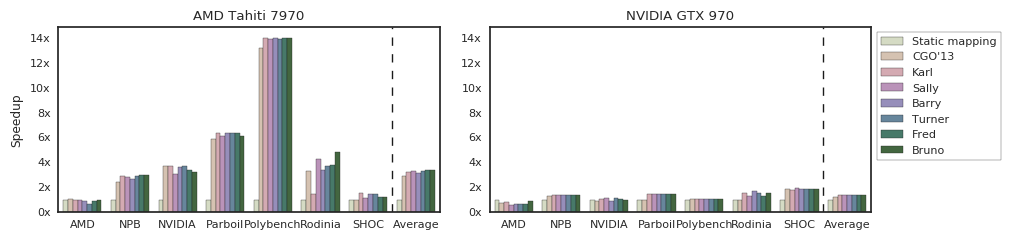

In [99]:
# for atomizer in atomizers:
#     print("Atomizer:", atomizer)
#     plot_ex1_graph(x="source", order=suite_names + ["Average"], y="acc", data=d, atomizer=atomizer)
    
for atomizer in atomizers:
    print("Atomizer:", atomizer)
    plot_ex1_graph(x="source", order=suite_names + ["Average"], y="p_speedup",
                   data=d, atomizer=atomizer, ylabel="Speedup", ylim=(0,15), yaxis_fmt="%dx")

### Accuracy

Atomizer: GreedyAtomizer


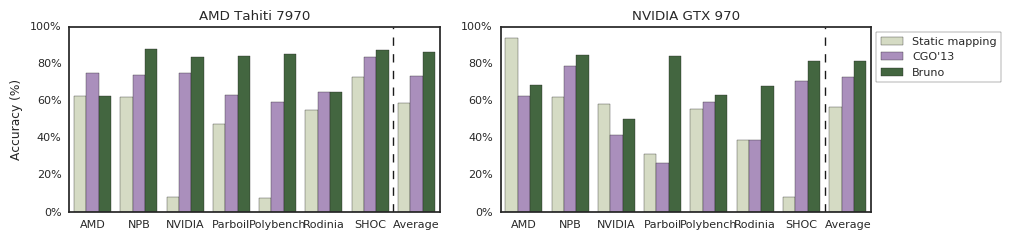

In [100]:
_d = d[(d["model_name"] == "Static mapping") | (d["model_name"] == "CGO'13") | (d["model_name"] == "Bruno")]
for atomizer in atomizers:
    print("Atomizer:", atomizer)
    plot_ex1_graph(x="source", order=suite_names + ["Average"], y="acc", data=_d, n_palette=3, atomizer=atomizer)

### Performance (% optimal)

Atomizer: GreedyAtomizer


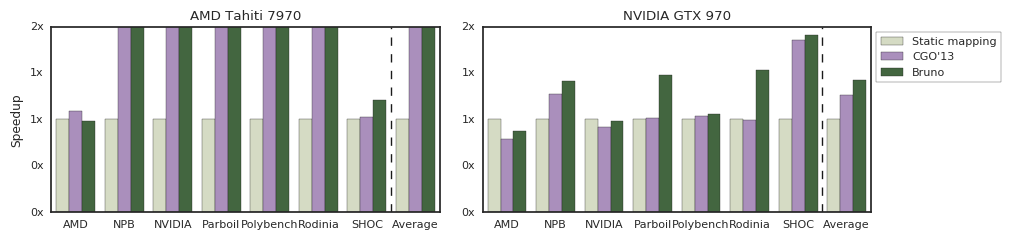

In [101]:
for atomizer in atomizers:
    print("Atomizer:", atomizer)
    plot_ex1_graph(x="source", order=suite_names + ["Average"], y="p_speedup", n_palette=3, 
                   data=_d, atomizer=atomizer, ylabel="Speedup", ylim=(0,2), yaxis_fmt="%dx")